### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: 1st page is empty

Current solution: Explicitly define page number

### Import Dump

In [1]:
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import pytesseract
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\paoma\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Scanning

First we convert the pdf into a png per page

In [2]:
pdf_name = "BNI_CORPORATE.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    name = pdf_name[:-4] + "-page-" + str(page.number) + ".png"
    pix.save(name)

Use an OCR (optical character recognition) model for reading text

In [2]:
# define tesseract OCT model 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Read the images to be put into an Image object in cv2

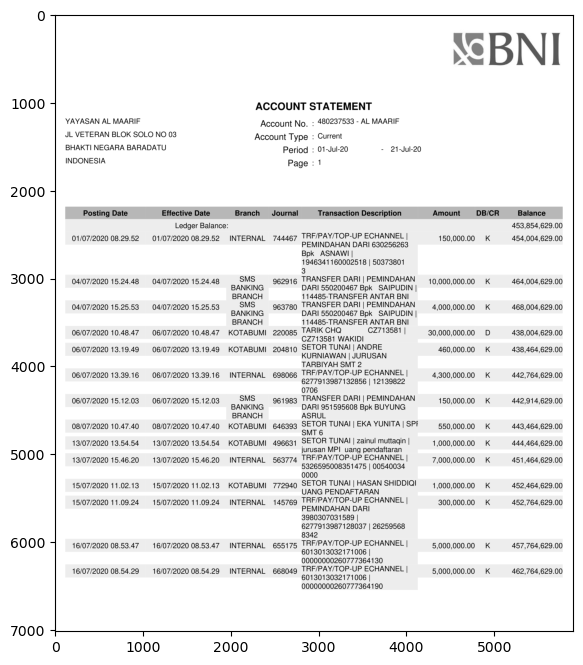

In [3]:
page_num = 0
page_name = "BNI_CORPORATE-page-" + str(page_num) + ".png"

# read png
page = cv2.imread(page_name)

# to grayscale for model to easily process
page = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

So for exaple, the height crop in the image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

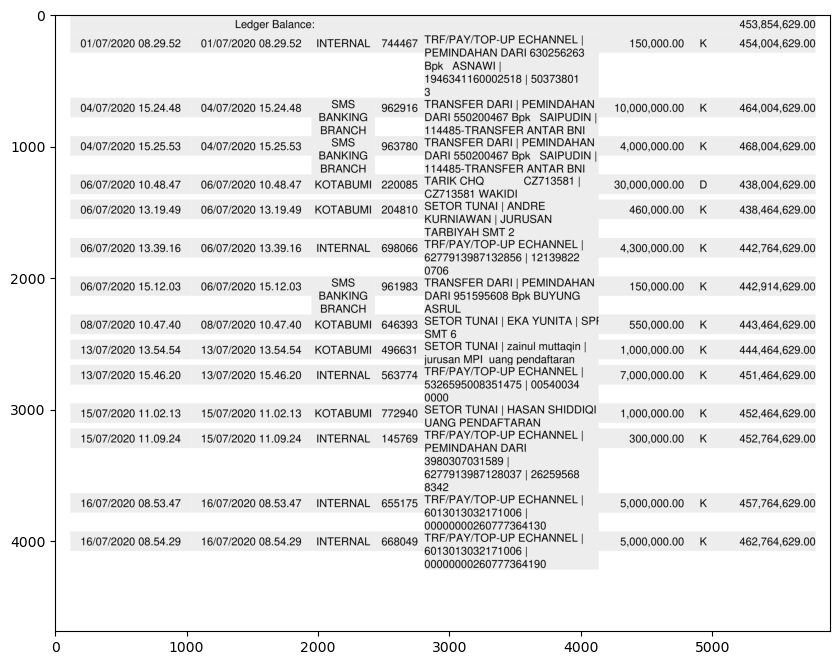

In [4]:
# get page height
page_height = page.shape[0]

page = page[int(page_height * 0.332):, :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")


Create a threshold for creating pure monochrome image

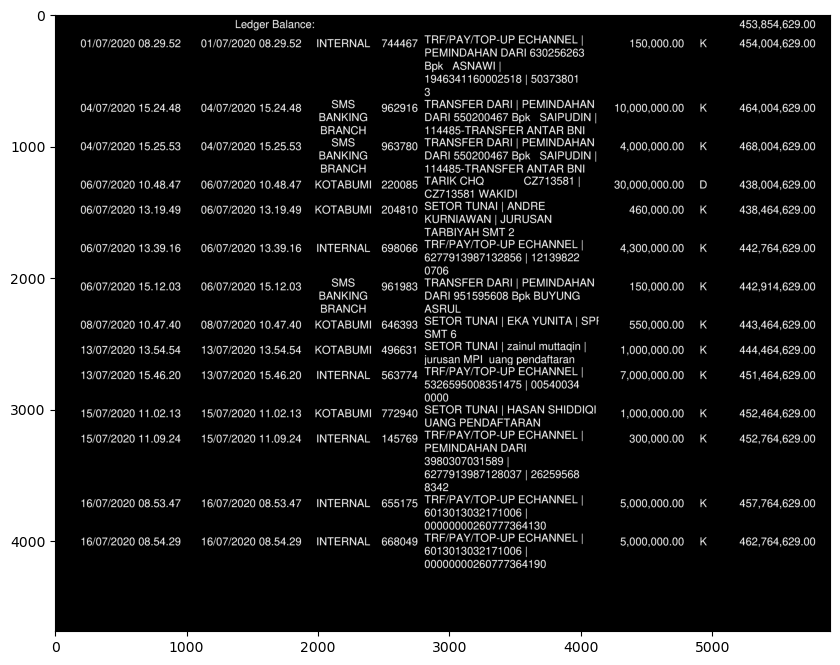

In [5]:
# define threshold
retval, thresh = cv2.threshold(page, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

Extract text using contours (rectangles around text) more simply for the model to detect characters.

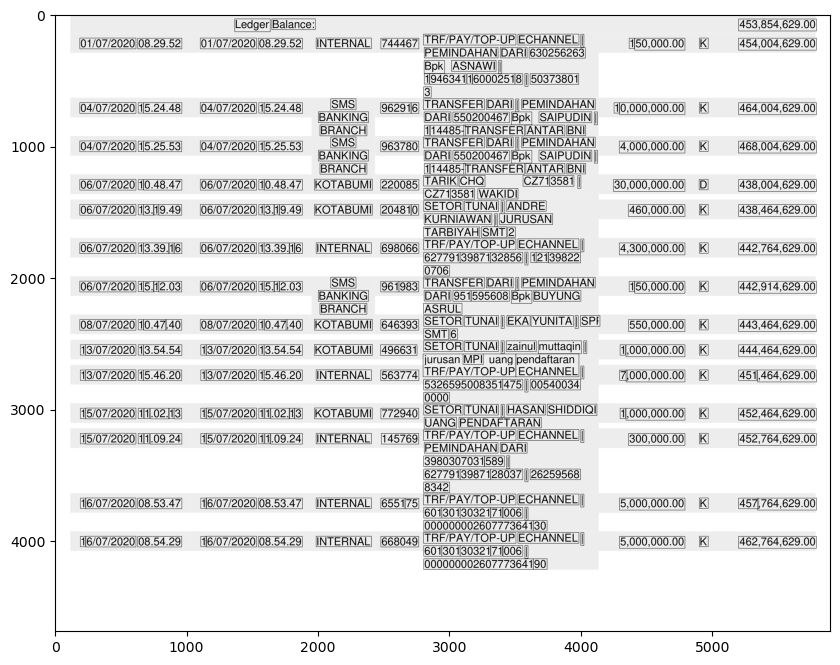

In [6]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 20))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# copy grayscale image from earlier to see the contours
page_copy = page.copy()

# make contour list to store text and its corresponding coordinates
cnt_list = []

# loop for each contour detected
for cnt in contours:

    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(page_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # crop text block by rectangle text block
    crop = page_copy[y:y+h, x:x+w]

    # use ocr model cropped image
    text = pytesseract.image_to_string(crop, config="--psm 13")

    # store coordinates and text
    cnt_list.append([x, y, text])

plt.figure(figsize=(30,8))
plt.imshow(page_copy, cmap="gray")

Sort text from left to right and from up to down

In [17]:
sorted_list = sorted(cnt_list, key = lambda x: x[0]) # sort by width first
sorted_list = sorted(sorted_list, key = lambda x: x[1]) # then height

sorted_list

[[1366, 29, 'Ledger\n'],
 [1648, 29, 'Balance:\n'],
 [5197, 30, '453,854,629.00\n'],
 [2801, 145, 'TRE/PAY/TOP-UP\n'],
 [3519, 145, 'ECHANNEL\n'],
 [3997, 146, '|\n'],
 [188, 175, '01/07/2020\n'],
 [1104, 175, '01/07/2020\n'],
 [1985, 175, 'INTERNAL\n'],
 [4899, 175, 'K\n'],
 [628, 176, '08.29.52\n'],
 [1545, 176, '08.29.52\n'],
 [2477, 176, '744467\n'],
 [4365, 176, '1\n'],
 [4407, 176, '50,000.00\n'],
 [5197, 176, '454,004,629.00\n'],
 [2807, 246, 'PEMINDAHAN\n'],
 [3385, 246, 'DARI\n'],
 [3604, 247, '630256263\n'],
 [3014, 345, 'ASNAWI\n'],
 [2806, 346, 'Bpk\n'],
 [3372, 346, '|\n'],
 [3572, 445, '|\n'],
 [2807, 446, '1\n'],
 [2849, 446, '946341\n'],
 [3132, 446, '1\n'],
 [3174, 446, '6000251\n'],
 [3497, 446, '8\n'],
 [3612, 446, '50373801\n'],
 [2802, 546, '3\n'],
 [2096, 637, 'SMS\n'],
 [2801, 637, 'TRANSFER\n'],
 [3279, 638, 'DARI\n'],
 [3502, 638, '|\n'],
 [3547, 638, 'PEMINDAHAN\n'],
 [188, 666, '04/07/2020\n'],
 [1104, 666, '04/07/2020\n'],
 [4899, 666, 'K\n'],
 [632, 667, '1

Make into DataFrame for 2D array manipulation to make it cleaner

In [32]:
# create dataframe
df = pd.DataFrame(sorted_list)
df.columns = ["x", "y", "Text"]

# omit trivial texts
df = df.drop(df[(df.Text == "")].index)

# Remove the \n in text
df["Text"] = df["Text"].str.replace("\n", "")
df = df.drop(df[(df.Text == "|") | (df.Text == "| |")].index)

df.head(20)

,x,y,Text
0,1366,29,Ledger
1,1648,29,Balance:
2,5197,30,"453,854,629.00"
3,2801,145,TRE/PAY/TOP-UP
4,3519,145,ECHANNEL
6,188,175,01/07/2020
7,1104,175,01/07/2020
8,1985,175,INTERNAL
9,4899,175,K
10,628,176,08.29.52


Each perceieved row in the image is seen to have a range of 2-5 pixels in its y (e.g. 43, 44, 45) by the model but it is important to make it so that it is in the same y that the paper is actually trying to tell

So replace a row's y point (defined as the top left of the row or contour) and everything that is near that y point (y+5) to be y

(To be optimized with df functions; or not? the runtime is 0s)

In [34]:
r = df[df["x"] == df["x"].min()]["y"].iloc[0]

for i in range(df.shape[0]):
    y = df["y"].iloc[i]

    if r-5 <= y <= r+5:
        df["y"].iloc[i] = r
    else:
        r = y

# sort again left to right, top to bottom
df = df.sort_values(by=["y", "x"])

for i in range(df.shape[0]):
    y = df["y"].iloc[i]
    next_y = y

    for j in range(df.shape[0]-i):
        new_y = df["y"].iloc[i+j]
        if new_y != next_y:
            next_y = new_y
            break
    
    if next_y-y < 35:
        df["y"].iloc[i] = next_y

# sort again left to right, top to bottom
df = df.sort_values(by=["y", "x"])

df.head(40)

C:\Users\paoma\AppData\Local\Temp\ipykernel_3160\2526260984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel_3160\2526260984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel_3160\2526260984.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel

,x,y,Text
0,1366,29,Ledger
1,1648,29,Balance:
2,5197,29,"453,854,629.00"
6,188,175,01/07/2020
10,628,175,08.29.52
7,1104,175,01/07/2020
11,1545,175,08.29.52
8,1985,175,INTERNAL
12,2477,175,744467
3,2801,175,TRE/PAY/TOP-UP


A row in the transaction is defined by each date's position. Similarly in the desired CSV, the same row shall have all of its elements with it. 

The date's x is always the most left (+/-5) so get the smallest x and split the dataset based on when each date is detected per row.

It is also desirable to make every element have its x known to detect which column it is in

Create a new DataFrame where columns store each column in the page (Tanggal, Keterangan, CBG, Mutasi, Saldo) and put each transaction row into one row. Keterangan will have multiple string elements concatenated

In [35]:
t = pd.DataFrame(columns=["Posting Date", "Effective Date", "Branch", "Journal", "Transaction Description", "Amount", "DB/CR", "Balance"])

Find each left x coordinate of each column. First do a manual search of each x coordinate by plotting vertical lines in the page

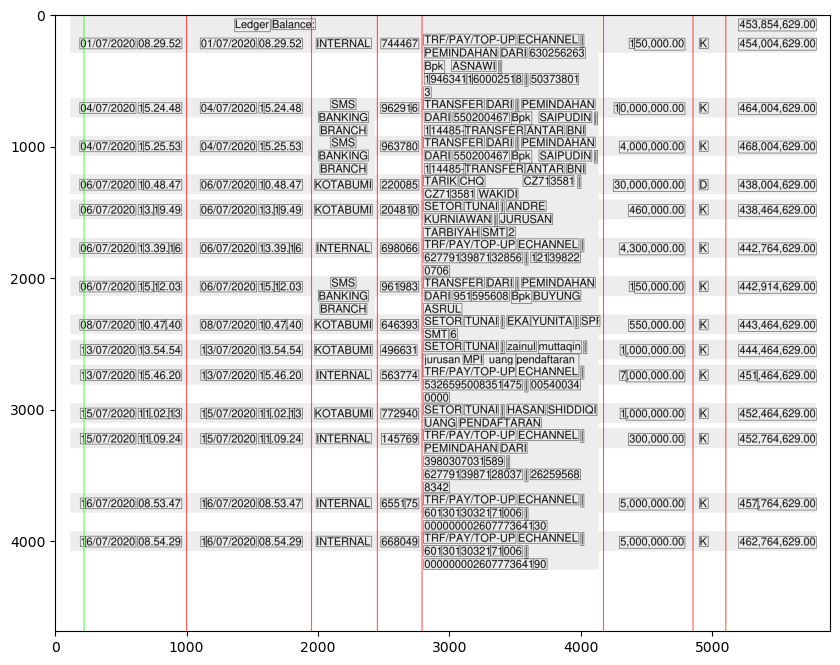

In [65]:
page_lines = page_copy.copy()
page_lines = cv2.cvtColor(page_lines, cv2.COLOR_GRAY2BGR)

cv2.line(page_lines, (220, 0), (220, page.shape[0]), (0, 255, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (1000, 0), (1000, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (1950, 0), (1950, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (2450, 0), (2450, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (2790, 0), (2790, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (4170, 0), (4170, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (4850, 0), (4850, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)
cv2.line(page_lines, (5100, 0), (5100, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)


plt.figure(figsize=(30, 8))
plt.imshow(page_lines)

Therefore for each column, its x coordinates are:
- Posting Date: 0 < x < 1000
- Effective Date: 1000 < x < 1950
- Branch: 1950 < x < 2450
- Journal: 2450 < x < 2790
- Transaction Description: 2790 < x < 4150
- Amount: 4150 < x < 4850
- DB/CR: 4850 < x < 5100
- Balance: 5100 < x < `page.shape[1]` (max x)

In [36]:
pdate = ""; edate = ""; branch = ""; journal = ""; tdesc = ""; amount = ""; dbcr = ""; bal = ""
pdates = []; edates = []; branchs = []; journals = []; tdescs = []; amounts = []; dbcrs = []; bals = []

# prevents summary at the end of pdf to be added
# exit = 0 # if SALDO and AWAL is detected in columns keterangan1 and keterangan2 correspondingly, append arrays and break

df = df._append({"x": 500, "y": 0, "Text": "a"}, ignore_index=True)

for i in range(df.shape[0]):
    x = df["x"].iloc[i]
    text = df["Text"].iloc[i]
    
    if x < 1000:
        if "Ledger" in edate:
            pdate = ""; edate = ""; branch = ""; journal = ""; tdesc = ""; amount = ""; dbcr = ""; bal = ""
        elif not (220 < x):
            pdates.append(pdate)
            edates.append(edate)
            branchs.append(branch)
            journals.append(journal)
            tdescs.append(tdesc)
            amounts.append(amount)
            dbcrs.append(dbcr)
            bals.append(bal)

            pdate = ""; edate = ""; branch = ""; journal = ""; tdesc = ""; amount = ""; dbcr = ""; bal = ""

        pdate += text

    elif 1000 < x < 1950:
        if text == "Ending": # last page
            pdates.append(pdate)
            edates.append(edate)
            branchs.append(branch)
            journals.append(journal)
            tdescs.append(tdesc)
            amounts.append(amount)
            dbcrs.append(dbcr)
            bals.append(bal)

            break
        else:
            edate += text
    elif 1950 < x < 2450:
        branch += text + " "
    elif 2450 < x < 2790:
        journal += text
    elif 2790 < x < 4170:
        tdesc += text + " "
    elif 4170 < x < 4850:
        amount += text
    elif 4850 < x < 5100:
        dbcr += text
    elif 5100 < x:
        bal += text


t = pd.DataFrame({
            "Posting Date": pdates,
            "Effective Date": edates,
            "Branch": branchs,
            "Journal": journals,
            "Transaction Description": tdescs,
            "Amount": amounts,
            "DB/CR": dbcrs,
            "Balance": bals
        })

t = t[t["Posting Date"].str.contains("a") == False] # delete

t

,Posting Date,Effective Date,Branch,Journal,Transaction Description,Amount,DB/CR,Balance
0,01/07/202008.29.52,01/07/202008.29.52,INTERNAL,744467,TRE/PAY/TOP-UP ECHANNEL PEMINDAHAN DARI 630256...,"150,000.00",K,"454,004,629.00"
1,04/07/202015.24.48,04/07/202015.24.48,SMS BANKING BRANCH,962916,TRANSFER DARI PEMINDAHAN DARI 550200467 Bpk SA...,"10,000,000.00",K,"464,004,629.00"
2,04/07/202015.25.53,04/07/202015.25.53,SMS BANKING BRANCH,963780,TRANSFER DARI PEMINDAHAN DARI 550200467 Bpk SA...,"4,000,000.00",K,"468,004,629.00"
3,06/07/202010.48.47,06/07/202010.48.47,KOTABUMI,220085,TARIK CHQ CZ71 3581 CZ71 3581 WAKIDI,"30,000,000.00",D,"438,004,629.00"
4,06/07/202013.19.49,06/07/202013.19.49,KOTABUMI,204810,SETOR TUNAI ANDRE KURNIAWAN JURUSAN TARBIYAH S...,"460,000.00",K,"438,464,629.00"
5,06/07/202013.39.16,"06/07/202013.39,16",INTERNAL,698066,TRE/PAY/TOP-UP ECHANNEL 627791 39871 32856 1 1...,"4,300,000.00",K,"442,764,629.00"
6,06/07/202015.12.03,06/07/202015.12.03,SMS BANKING BRANCH,961983,TRANSFER DARI PEMINDAHAN DARI 951 595608 Bpk B...,"150,000.00",K,"442,914,629.00"
7,08/07/202010.47.40,08/07/202010.47.40,KOTABUMI,646393,SETOR TUNAI EKA YUNITA SPH SMT 6,"550,000.00",K,"443,464,629.00"
8,13/07/202013.54.54,13/07/202013.54.54,KOTABUMI,496631,SETOR TUNAI Zainul muttaqin Poe ee MPI ee,"1,000,000.00",K,"444 464,629.00"
9,13/07/202015.46.20,13/07/202015.46.20,INTERNAL,563774,5326595008351 475 00540034 0000,"7{000,000.00",K,"451,464,629.00"


String postprocessing so the csv looks neater

In [41]:
# remove every element's last character (which is some unnecessary space)
for col in t.columns:
    if col != "Tanggal":
        t[col] = t[col].str[:-1]

In [42]:
# remove spacing in saldo
t["Mutasi"] = t["Mutasi"].str.replace(" ", "")

# remove string in saldo
for i in range(t.shape[0]):
    m = t["Mutasi"].iloc[i]

    if m != "":
        for c in range(len(m)):
            if m[-1:].isalpha():
                m = m[:-1]

        if m[-3:-2] != ".":
            m = m[:-2] + "." + m[-2:]

        t["Mutasi"].iloc[i] = m

# replace V with / in tanggal
for i in range(t.shape[0]):
     m = t["Tanggal"].iloc[i]

     t["Tanggal"].iloc[i] = m.replace("V", "/")

t

C:\Users\paoma\AppData\Local\Temp\ipykernel_18396\1860913889.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  t["Mutasi"].iloc[i] = m
C:\Users\paoma\AppData\Local\Temp\ipykernel_18396\1860913889.py:16: FutureWarning: ChainedAssignmentErr

,Tanggal,Keterangan 1,Keterangan 2,CBG,Mutasi,Saldo
0,28/07,SWITCHING DB,BIAYA TXN KE 213 ARIE SETYA YUDHA /KBB,,"6,500.00","662 926,445 63"
1,28/07,TRSF E-BANKING CR,28/07 /95031/00000 314986300.00 VELOX RICON LO...,,"314,986,300.00",
2,28/07,TRSF E-BANKING CR,"2807 V FTSCY, /WS95041 HONU SIZE 40,45 ,46 MUG...",,"331,752,000.00",
3,28/07,TRSF E-BANKING DB,"2807 VFTSCY, /WS95051 299467200.00 CNTN MOLAY ...",,"299,467200.00","1,010, 197 545 63"
4,29/07,SWITCHING CR,TRANSFER DR 049 TMAM DIPSA MAULANA / 81228109345,,"288,700,000.00",
5,29/07,TRSF E-BANKING CR,29/07 /95031/00000 TAGIHAN BSO PETER RIADI,,"227650,000.00",
6,29/07,TRSF E-BANKING DB,"2907 VFTSCY, /WS95051 375000000.00 DIAH SUPROB...",,"375,000,000.00",
7,29/07,TRSF E-BANKING DB,"2907 VFTSCY, /WS95051 299896500.00 TNV 014/MST...",,"299,896,500.00","851, 651,045 63"
8,31/07,BIAYA ADM,,,"30,000.00","851, 621,045 63"


Finally put the dataframe into csv

In [246]:
final = t.copy()

final.to_csv("transactions.csv", index=False, sep=";")